In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
def get_train_val(filepath: str, val_size=0.2):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1], row[2], row[3] = int(row[1]), int(row[2]), int(row[3])
            data.append(row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id', 'species', 'breed'])
    
    # Replace 1 with 0 (for cats) and 2 with 1 (for dogs)
    df['species'] = df['species'].replace({1: 0, 2: 1})
    # Define the mapping dictionary
    label_mapping_breed = {i: i - 1 for i in range(1, 26)} # if there are 25 labels
    # Replace the labels in the 'species' column using the mapping dictionary
    df['breed'] = df['breed'].replace(label_mapping_breed)

    label_mapping_class = {i: i - 1 for i in range(1, 38)} # if there are 37 labels
    # Replace the labels in the 'species' column using the mapping dictionary
    df['class_id'] = df['class_id'].replace(label_mapping_class)

    #train_df, val_df = train_test_split(df, test_size=val_size, stratify=df['species'], shuffle=True, random_state=42)
    train_df, val_df = train_test_split(df, test_size=val_size, stratify=df['class_id'], shuffle=True, random_state=42)
    return train_df, val_df

In [3]:
def load_and_transform_image(image_path):
    """ Load an image and apply the transformations. """
    
    # Define the transformations (we use the same as what Resnet used for efficient transfer)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')  # Convert all images to RGB
    return transform(image)



In [4]:
# Function to create a tensor dataset from DataFrame and transformations
def create_dataset(df, base_path):
    images_tensors = []
    Y = []
    for row in df.values.tolist():
        #image_id, species_id = row[0], row[2]
        image_id, class_id = row[0], row[1]
        image_path = f"{base_path}{image_id}.jpg"  # Adjust format as needed
        image_tensor = load_and_transform_image(image_path)
        images_tensors.append(image_tensor)
        #Y.append(species_id)
        Y.append(class_id)
    
    # Stack all tensors to create a single tensor
    X = torch.stack(images_tensors)
    Y = torch.tensor(np.array(Y))
    return X, Y

In [5]:
train_df, val_df = get_train_val('C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\annotations\\annotations\\trainval.txt')
#c:/Users/alexa/Documents/Deep Learning/Project/datasets/annotations/trainval.txt

base_path = "C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\images\\images\\"

#c:/Users/alexa/Documents/Deep Learning/Project/datasets/images/

# Creating the datasets
X_train, Y_train = create_dataset(train_df, base_path)
X_val, Y_val = create_dataset(val_df, base_path)

In [8]:
print(X_train.shape)
print(X_val.shape)

labels = torch.unique(Y_train)
print(labels)


torch.Size([2944, 3, 224, 224])
torch.Size([736, 3, 224, 224])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36], dtype=torch.int32)


In [13]:
def get_test(filepath: str):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1], row[2], row[3] = int(row[1]), int(row[2]), int(row[3])
            data.append(row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id', 'species', 'breed'])
    
    # Replace 1 with 0 (for cats) and 2 with 1 (for dogs)
    #df['species'] = df['species'].replace({1: 0, 2: 1})


    label_mapping_class = {i: i - 1 for i in range(1, 38)} # if there are 37 labels
    # Replace the labels in the 'species' column using the mapping dictionary
    df['class_id'] = df['class_id'].replace(label_mapping_class)

    return df
def create_dataset_mltclass(df, base_path, augment=False):
    images_tensors = []
    Y = []
    for row in df.values.tolist():
        image_id, breed_id = row[0], row[1] 
        image_path = f"{base_path}{image_id}.jpg" 
        image_tensor = load_and_transform_image(image_path)
        images_tensors.append(image_tensor)
        Y.append(breed_id)
    
    # Stack all tensors to create a single tensor
    X = torch.stack(images_tensors)
    Y = torch.tensor(np.array(Y))
    return X, Y

In [14]:
df_test = get_test(filepath='C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\annotations\\annotations\\test.txt')
X_test, Y_test = create_dataset_mltclass(df_test, base_path="C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\images\\images\\")

In [15]:
print(X_test.shape)

torch.Size([3669, 3, 224, 224])


In [8]:
def show_images(images, labels, n_images=None, figsize=(8, 8)):
    """
    Display a grid of images with labels.

    Args:
    images (torch.Tensor): The tensor containing image data.
    labels (list or torch.Tensor): List or tensor of labels.
    n_images (int): Number of images to display. Displays all if None.
    figsize (tuple): Figure size for the plot.
    """
    if n_images is None:
        n_images = len(images)
    else:
        images = images[:n_images]
        labels = labels[:n_images]
    
    num_rows = int(np.ceil(n_images**0.5))
    num_cols = int(np.ceil(n_images / num_rows))

    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # The image tensor shape should be (channels, height, width)
        img = img.permute(1, 2, 0).numpy()  # Convert to (height, width, channels)
        ax.imshow(img)
        ax.axis('off')  # Hide the axes ticks
        ax.set_title(f"Label: {label.item()}", fontsize=10)  # Set title to the label of the image

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


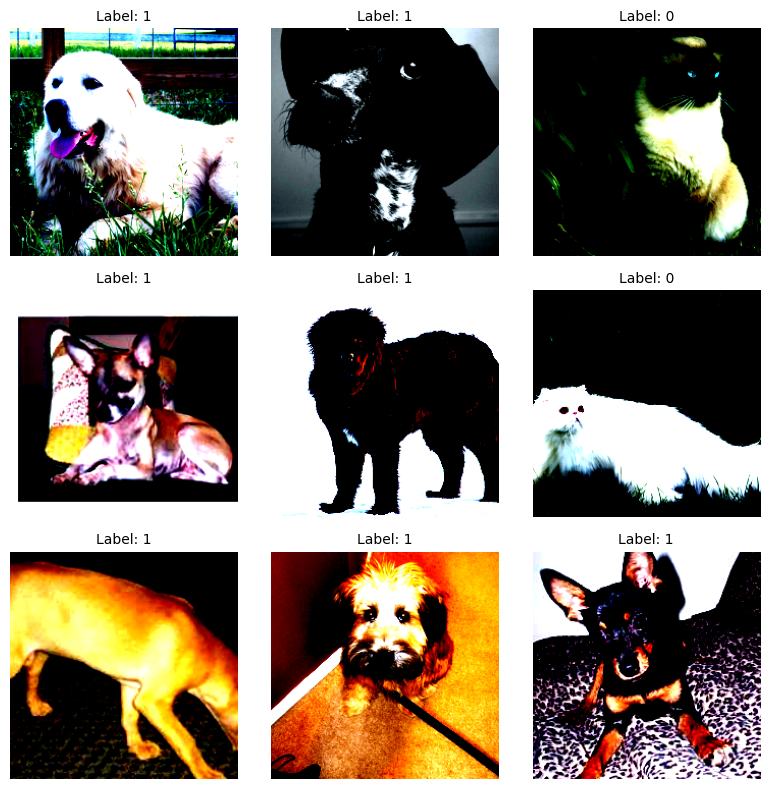

In [9]:
show_images(X_train, Y_train, 9)

In [10]:
print(X_train.shape)

torch.Size([2944, 3, 224, 224])
